In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype as Category
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
import numpy as np
from iterextras import par_for
import subprocess as sp
import os
import itertools
from tqdm.auto import tqdm
import rs_utils
from scipy.stats import gmean
import matplotlib as mpl
import json
import statsmodels.formula.api as sm


sns.set()

In [2]:
PATHS = glob('../data/*.json')
CRATES = [os.path.splitext(os.path.basename(path))[0] for path in PATHS]
CATEGORIES = {
    'mutability_mode': Category(["DistinguishMut", "IgnoreMut"]),
    'context_mode': Category(["Recurse", "SigOnly"]),
    'pointer_mode': Category(["Conservative", "Precise"]),
    'crate': Category(sorted(CRATES))
}

def parse_data(path):
    print(path)
    if os.stat(path).st_size == 0:
        return []
    
    crate = os.path.splitext(os.path.basename(path))[0]
    df = pd.DataFrame(rs_utils.parse_data(path))
    df['crate'] = crate
    for k, dt in CATEGORIES.items():
        df[k] = df[k].astype(dt)
    return df


all_dfs = par_for(parse_data, PATHS)
df = pd.concat(all_dfs).reset_index()
del all_dfs

# df = df[(df.num_relevant_instructions != 0)]
df['ins_rel_nonzero'] = df.instructions_relative > 0

../data/rav1e.json
../data/hyper.json
../data/image.json
../data/RustPython.json
../data/rg3d.json
../data/rayon.json
../data/rustls.json
../data/Rocket.json
../data/nalgebra.json
../data/sccache.json


  0%|          | 0/10 [00:01<?, ?it/s]

In [3]:
len(df.function_path.unique())

14696

In [4]:
len(df)/8

429200.0

In [5]:
df['ins_rel_frac_log'] = np.log(df.instructions_relative_frac)

/raid/wcrichto/flowistry-experiments/.env/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [6]:
def cond(df, m=None, c=None, p=None):
    if m is not None:
        df = df[df.mutability_mode == m]
    if c is not None:
        df = df[df.context_mode == c]
    if p is not None:
        df = df[df.pointer_mode == p]
    return df

modular_cond = cond(df, c='SigOnly', m='DistinguishMut', p='Precise')
modular_metric = modular_cond.instructions_relative_frac
mutblind_cond = cond(df, c='SigOnly', m='IgnoreMut', p='Precise')
mutblind_metric = mutblind_cond.instructions_relative_base_frac
refblind_cond = cond(df, c='SigOnly', m='DistinguishMut', p='Conservative')
refblind_metric = refblind_cond.instructions_relative_base_frac
whole_cond = cond(df, c='Recurse', m='DistinguishMut', p='Precise')

In [7]:
df2 = cond(df, m='DistinguishMut', c='Recurse', p='Precise')
print(len(df2[df2.instructions_relative > 0]) / len(df2))
df2[df2.instructions_relative > 0].sort_values('num_instructions')[20:40]

8.1547064305685e-05


,index,mutability_mode,context_mode,pointer_mode,sliced_local,function_range,function_path,num_instructions,num_relevant_instructions,duration,...,has_same_type_ptrs_in_input,reached_library,instructions_relative,instructions_relative_frac,instructions_relative_base,instructions_relative_base_frac,baseline_reached_library,crate,ins_rel_nonzero,ins_rel_frac_log
2637456,76688,DistinguishMut,Recurse,Precise,118,"{'start': 20320, 'end': 22891, 'filename': 'sr...",rayon[48a3]::slice::mergesort::recurse,159,41,0.004105,...,False,False,16.0,0.640000,16.0,0.640000,False,rayon,True,-0.446287
2574280,13512,DistinguishMut,Recurse,Precise,119,"{'start': 20320, 'end': 22891, 'filename': 'sr...",rayon[48a3]::slice::mergesort::recurse,159,41,0.004105,...,False,False,16.0,0.640000,16.0,0.640000,False,rayon,True,-0.446287
1979136,703224,DistinguishMut,Recurse,Precise,87,"{'start': 12109, 'end': 14009, 'filename': 'vm...",rustpython_vm[dc78]::frame::{impl#4}::gen_throw,203,44,0.011321,...,False,True,1.0,0.023256,-1.0,-0.022222,True,RustPython,True,-3.761200
1902704,626792,DistinguishMut,Recurse,Precise,81,"{'start': 12109, 'end': 14009, 'filename': 'vm...",rustpython_vm[dc78]::frame::{impl#4}::gen_throw,203,41,0.011321,...,False,True,1.0,0.025000,-1.0,-0.023810,True,RustPython,True,-3.688879
2006160,730248,DistinguishMut,Recurse,Precise,75,"{'start': 12109, 'end': 14009, 'filename': 'vm...",rustpython_vm[dc78]::frame::{impl#4}::gen_throw,203,40,0.011321,...,False,True,1.0,0.025641,-1.0,-0.024390,True,RustPython,True,-3.663562
1748504,472592,DistinguishMut,Recurse,Precise,86,"{'start': 12109, 'end': 14009, 'filename': 'vm...",rustpython_vm[dc78]::frame::{impl#4}::gen_throw,203,43,0.011321,...,False,True,1.0,0.023810,-1.0,-0.022727,True,RustPython,True,-3.737670
1324216,48304,DistinguishMut,Recurse,Precise,85,"{'start': 12109, 'end': 14009, 'filename': 'vm...",rustpython_vm[dc78]::frame::{impl#4}::gen_throw,203,46,0.011321,...,False,True,1.0,0.022222,-1.0,-0.021277,True,RustPython,True,-3.806662
1617904,341992,DistinguishMut,Recurse,Precise,80,"{'start': 12109, 'end': 14009, 'filename': 'vm...",rustpython_vm[dc78]::frame::{impl#4}::gen_throw,203,43,0.011321,...,False,True,1.0,0.023810,-1.0,-0.022727,True,RustPython,True,-3.737670
1587944,312032,DistinguishMut,Recurse,Precise,84,"{'start': 12109, 'end': 14009, 'filename': 'vm...",rustpython_vm[dc78]::frame::{impl#4}::gen_throw,203,45,0.011321,...,False,True,1.0,0.022727,-1.0,-0.021739,True,RustPython,True,-3.784190
1502016,226104,DistinguishMut,Recurse,Precise,83,"{'start': 12109, 'end': 14009, 'filename': 'vm...",rustpython_vm[dc78]::frame::{impl#4}::gen_throw,203,45,0.011321,...,False,True,1.0,0.022727,-1.0,-0.021739,True,RustPython,True,-3.784190


In [8]:
row = df2[df2.instructions_relative_frac > 0].sort_values('num_instructions').iloc[20]
df[(df.function_path == row.function_path) & (df.sliced_local == row.sliced_local)]

,index,mutability_mode,context_mode,pointer_mode,sliced_local,function_range,function_path,num_instructions,num_relevant_instructions,duration,...,has_same_type_ptrs_in_input,reached_library,instructions_relative,instructions_relative_frac,instructions_relative_base,instructions_relative_base_frac,baseline_reached_library,crate,ins_rel_nonzero,ins_rel_frac_log
2637456,76688,DistinguishMut,Recurse,Precise,118,"{'start': 20320, 'end': 22891, 'filename': 'sr...",rayon[48a3]::slice::mergesort::recurse,159,41,0.004105,...,False,False,16.0,0.64,16.0,0.64,False,rayon,True,-0.446287
2637457,76689,DistinguishMut,Recurse,Conservative,118,"{'start': 20320, 'end': 22891, 'filename': 'sr...",rayon[48a3]::slice::mergesort::recurse,159,41,0.004334,...,False,False,16.0,0.64,16.0,0.64,False,rayon,True,-0.446287
2637458,76690,DistinguishMut,SigOnly,Precise,118,"{'start': 20320, 'end': 22891, 'filename': 'sr...",rayon[48a3]::slice::mergesort::recurse,159,25,0.003962,...,False,False,0.0,0.00,0.0,0.00,False,rayon,False,-inf
2637459,76691,DistinguishMut,SigOnly,Conservative,118,"{'start': 20320, 'end': 22891, 'filename': 'sr...",rayon[48a3]::slice::mergesort::recurse,159,25,0.003803,...,False,False,0.0,0.00,0.0,0.00,False,rayon,False,-inf
2637460,76692,IgnoreMut,Recurse,Precise,118,"{'start': 20320, 'end': 22891, 'filename': 'sr...",rayon[48a3]::slice::mergesort::recurse,159,64,0.003281,...,False,False,39.0,1.56,39.0,1.56,False,rayon,True,0.444686
2637461,76693,IgnoreMut,Recurse,Conservative,118,"{'start': 20320, 'end': 22891, 'filename': 'sr...",rayon[48a3]::slice::mergesort::recurse,159,64,0.003718,...,False,False,39.0,1.56,39.0,1.56,False,rayon,True,0.444686
2637462,76694,IgnoreMut,SigOnly,Precise,118,"{'start': 20320, 'end': 22891, 'filename': 'sr...",rayon[48a3]::slice::mergesort::recurse,159,25,0.003252,...,False,False,0.0,0.00,0.0,0.00,False,rayon,False,-inf
2637463,76695,IgnoreMut,SigOnly,Conservative,118,"{'start': 20320, 'end': 22891, 'filename': 'sr...",rayon[48a3]::slice::mergesort::recurse,159,25,0.003953,...,False,False,0.0,0.00,0.0,0.00,False,rayon,False,-inf


In [9]:
row.function_path

'rayon[48a3]::slice::mergesort::recurse'

# Dataset summary

## Crates

In [10]:
CRATE_INFO = [
    ('Rocket', 'core/lib', 'Web backend framework', 'https://github.com/SergioBenitez/Rocket'),
    ('image', None, 'Image processing library', 'https://github.com/image-rs/image'),
    ('rayon', None, 'Data parallelism library', 'https://github.com/rayon-rs/rayon'),
    ('rg3d', None, '3D game engine', 'https://github.com/mrDIMAS/rg3d'),    
    ('nalgebra', None, 'Numerics library', 'https://github.com/dimforge/nalgebra'),
    ('rustls', 'rustls', 'TLS implementation', 'https://github.com/ctz/rustls'),
    ('sccache', None, 'Distributed build cache', 'https://github.com/mozilla/sccache'),
    ('hyper', None, 'HTTP server', 'https://github.com/hyperium/hyper'),    
    ('rav1e', None, 'Video encoder', 'https://github.com/xiph/rav1e'),
    ('RustPython', 'vm', 'Python interpreter', 'https://github.com/RustPython/RustPython'),
]

In [11]:
modular_cond_funcs = modular_cond.groupby(['crate', 'function_path']) \
    .apply(lambda df: df.iloc[0]).reset_index(drop=True)
num_slices = modular_cond.groupby(['crate']).size().rename('num_slices')
avg_ins_per_func = modular_cond_funcs.groupby('crate').num_instructions.mean() \
    .rename('avg_ins_per_func')
num_funcs = modular_cond.groupby(['crate']).apply(lambda df: len(df.function_path.unique())).rename('num_funcs')

q = modular_cond.groupby(['crate', 'function_path']).size()
avg_slices_per_func = q[q > 0] \
    .groupby('crate').mean().rename('avg_slices_per_func')
crate_stats = pd.concat(
    [num_slices, avg_ins_per_func, num_funcs, avg_slices_per_func], 
    axis=1).sort_values('num_slices')
crate_stats

,num_slices,avg_ins_per_func,num_funcs,avg_slices_per_func
crate,,,,
rayon,10695,16.678406,1079,9.911956
Rocket,12618,26.609987,741,17.028340
rustls,23884,43.202765,868,27.516129
sccache,24705,63.841369,643,38.421462
nalgebra,37202,27.634174,1785,20.841457
hyper,40001,77.155696,790,50.634177
image,40672,58.600365,1096,37.109489
rg3d,60928,26.191705,3448,17.670534
rav1e,78816,118.064447,931,84.657358


In [12]:
CLOC = '/home/wcrichto/.node_modules/bin/cloc'
crate_loc = []
for (crate, path, purpose, url) in CRATE_INFO:
    crate_dir = f'../data/repos/{crate}'
    if path:
        crate_dir += f'/{path}'
    crate_dir += '/src'    
    cloc_str = sp.check_output(f'{CLOC} {crate_dir} --json', shell=True).strip()
    commit = sp.check_output('git rev-parse HEAD', shell=True, cwd=crate_dir).strip().decode('utf-8')
    cloc = json.loads(cloc_str)
    crate_loc.append({
        "crate": crate,
        'subdir': path,
        'purpose': purpose,
        "url": url,
        "commit": commit,
        "loc": cloc["Rust"]["code"],
    })
crate_loc = pd.DataFrame(crate_loc)

In [13]:
crate_final = crate_stats.join(crate_loc.set_index("crate")).sort_values('num_slices')
for crate, row in  crate_final.iterrows():
    print(f'\href{{{row.url}}}{{{crate}}} & {row.subdir or ""} & {row.purpose} & {row["loc"]:,} & \
{row.num_slices:,} & {row.num_funcs:,} & {row.avg_ins_per_func:.1f} \\\\ \hline')

\href{https://github.com/rayon-rs/rayon}{rayon} &  & Data parallelism library & 15,524 & 10,695 & 1,079 & 16.7 \\ \hline
\href{https://github.com/SergioBenitez/Rocket}{Rocket} & core/lib & Web backend framework & 9,313 & 12,618 & 741 & 26.6 \\ \hline
\href{https://github.com/ctz/rustls}{rustls} & rustls & TLS implementation & 16,866 & 23,884 & 868 & 43.2 \\ \hline
\href{https://github.com/mozilla/sccache}{sccache} &  & Distributed build cache & 23,202 & 24,705 & 643 & 63.8 \\ \hline
\href{https://github.com/dimforge/nalgebra}{nalgebra} &  & Numerics library & 31,951 & 37,202 & 1,785 & 27.6 \\ \hline
\href{https://github.com/hyperium/hyper}{hyper} &  & HTTP server & 15,082 & 40,001 & 790 & 77.2 \\ \hline
\href{https://github.com/image-rs/image}{image} &  & Image processing library & 20,722 & 40,672 & 1,096 & 58.6 \\ \hline
\href{https://github.com/mrDIMAS/rg3d}{rg3d} &  & 3D game engine & 54,426 & 60,928 & 3,448 & 26.2 \\ \hline
\href{https://github.com/xiph/rav1e}{rav1e} &  & Video enc

In [14]:
print(f'{crate_final["loc"].sum():,} & {crate_final.num_slices.sum():,} & {crate_final.num_funcs.sum():,}')

285,307 & 429,200 & 14,696


In [15]:
total_vs_nz = mutblind_cond.groupby('crate').apply(lambda df: pd.DataFrame([{
    'total': crate_final.num_slices[df.crate.iloc[0]],
    'nz': len(df[df.instructions_relative_base > 0])
}]))

result = sm.ols('nz ~ total', data=total_vs_nz).fit()
result.summary()

/raid/wcrichto/flowistry-experiments/.env/lib/python3.7/site-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     nz   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     46.51
Date:                Fri, 12 Nov 2021   Prob (F-statistic):           0.000135
Time:                        19:30:07   Log-Likelihood:                -98.327
No. Observations:                  10   AIC:                             200.7
Df Residuals:                       8   BIC:                             201.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -683.7935   2959.111     -0.231      0.823   -7507.517    6139.930
total          0.3961      0.058      6.820      0.000       0.262       0.530
==============================================================================
Omnibus:                        2.031   Durbin-Watson:                   2.132
Prob(Omnibus):                  0.362   Jarque-Bera (JB):                0.857
Skew:                          -0.712   Prob(JB):                        0.651
Kurtosis:                       2.832   Cond. No.                     9.46e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.46e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [16]:
crate_final.reset_index()[['crate', 'commit']]

,crate,commit
0,rayon,c571f8ffb4f74c8c09b4e1e6d9979b71b4414d07
1,Rocket,8d4d01106e2e10b08100805d40bfa19a7357e900
2,rustls,cdf1dada21a537e141d0c6dde9c5685bb43fbc0e
3,sccache,3f318a8675e4c3de4f5e8ab2d086189f2ae5f5cf
4,nalgebra,984bb1a63943aa68b6f26ff4a6acf8f68b833b70
5,hyper,ed2fdb7b6a2963cea7577df05ddc41c56fee7246
6,image,e916e9dda5f4253f6cc4557b0fe5fa3876ac18e5
7,rg3d,ca7b85f2b30e45b82caee0591ee1abf65bb3eb00
8,rav1e,1b6643324752785e7cd6ad0b19257f3c3a9b2c6a
9,RustPython,9143e51b7524a5084d5ed230b1f2f5b0610ac58b


## Dataset size

In [17]:
print(f'{len(df) // 8:,}')

429,200


## Execution time

In [18]:
durations = cond(df, m='DistinguishMut', p='Precise').groupby(['context_mode', 'function_path']) \
    .apply(lambda df: df.iloc[0].duration)

In [42]:
durations.groupby('context_mode').median() * 1e6

context_mode
Recurse    169.033
SigOnly    199.736
dtype: float64

In [20]:
durations.groupby('context_mode').max()

context_mode
Recurse    49.097970
SigOnly    50.844099
dtype: float64

## Metadata

In [21]:
len(modular_cond[modular_cond.reached_library]) / len(modular_cond)

0.9604962721342032

In [22]:
modular_cond.groupby('reached_library').apply(lambda df: len(df[df.ins_rel_nonzero]) / len(df))

reached_library
False    0.013035
True     0.105680
dtype: float64

# Exploration

In [23]:
nz = refblind_cond[(refblind_cond.instructions_relative_base_frac > 0) & \
                       (refblind_cond.sliced_local < 3) & (refblind_cond.crate == 'rg3d')]
nz.sort_values('num_instructions', ascending=True)[:20][['function_path', 'sliced_local', 'num_instructions']]


,function_path,sliced_local,num_instructions
2194395,rg3d[21e3]::renderer::{impl#8}::end_frame,0,29
2236291,rg3d[21e3]::scene::graph::{impl#1}::unlink_int...,2,46
2317379,rg3d[21e3]::renderer::framework::gpu_program::...,2,110
2429395,rg3d[21e3]::resource::fbx::scene::link_child_w...,2,118
2312659,rg3d[21e3]::resource::fbx::load_to_scene,1,268
2403419,rg3d[21e3]::renderer::surface::{impl#5}::calcu...,2,348
2092627,rg3d[21e3]::utils::astar::{impl#6}::build,0,416
2495787,rg3d[21e3]::utils::astar::{impl#6}::build,1,416
2384947,rg3d[21e3]::resource::texture::{impl#12}::load...,0,481
2385323,rg3d[21e3]::renderer::ui_renderer::{impl#1}::r...,1,729


In [24]:
# row = nz.loc[2172883]
# df[(df.function_path == row.function_path) & (df.sliced_local == row.sliced_local)]

In [25]:
df2 = cond(df, c='SigOnly', m='IgnoreMut', p='Precise')
nz = df2[(df2.instructions_relative_frac > 0)]
n = 2000
nz.sort_values('instructions_relative_frac', ascending=False)[n:n+20][['function_path', 'sliced_local', 'num_instructions']]


,function_path,sliced_local,num_instructions
1772846,rustpython_vm[dc78]::stdlib::builtins::make_mo...,698,1057
1379678,rustpython_vm[dc78]::stdlib::builtins::make_mo...,176,1057
1612062,rustpython_vm[dc78]::stdlib::builtins::make_mo...,92,1057
1437870,rustpython_vm[dc78]::stdlib::builtins::make_mo...,419,1057
1600894,rustpython_vm[dc78]::stdlib::builtins::make_mo...,239,1057
1731118,rustpython_vm[dc78]::stdlib::builtins::make_mo...,383,1057
1599942,rustpython_vm[dc78]::stdlib::builtins::make_mo...,335,1057
1479374,rustpython_vm[dc78]::stdlib::builtins::make_mo...,110,1057
1614022,rustpython_vm[dc78]::stdlib::builtins::make_mo...,497,1057
1559478,rustpython_vm[dc78]::stdlib::builtins::make_mo...,641,1057



# Slice size analysis

In [26]:
def plot_ins(data, xscale='linear', yscale='linear', nz=False, ax=None, quantile=None, bins=None, **kwargs):
    if nz:
        data = data[data > 0]        
        
    if bins is None:
        max = data.max()
        if 'log' in xscale:
            bins = np.logspace(np.log10(0.0001), np.log10(max))
            if not nz:
                bins = np.concatenate(([0.], bins))
        else:
            bins = np.linspace(0, max, 30)

    ax = sns.histplot(data, bins=bins, ax=ax)
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    
    if xscale == 'symlog':
        nz_min = data[data > 0].min()
        ax.set_xscale(xscale, linthresh=nz_min)
        ax.set_xlim(-nz_min/2, data.max())
        
    ax.set_xlabel('\% increase in dependency set size' + (', log scale' if 'log' in xscale else ''))
    ax.set_ylabel('Count' + (', log scale' if yscale == 'log' else ''))

    if quantile is not None:
        x = data.quantile(quantile)
        ax.axvline(x, color='r')        

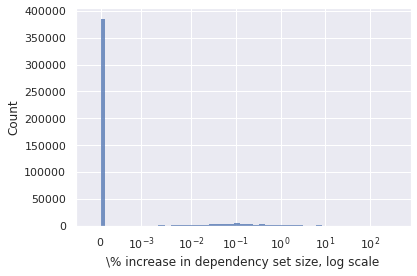

In [27]:
plot_ins(modular_metric, xscale='symlog')

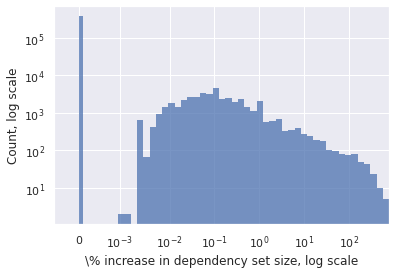

In [28]:
plot_ins(modular_metric, xscale='symlog', yscale='log')

In [29]:
data = modular_metric[modular_metric > 0]

In [30]:
from scipy import stats as s
from scipy.stats._continuous_distns import _distn_names
from iterextras import par_for

y, x = np.histogram(data, bins=1000, density=True)
x = (x + np.roll(x, -1))[:-1] / 2.0

distn_names = [
    'loguniform', 'powernorm', 'powerlaw', 'powerlognorm', 'chi', 'chi2', 'lognorm', 'weibull_max', 'gamma',
    'norm', 'beta', 'gumbel_r', 'pareto', 'lognormal', 'loggamma', 'skewnorm', 
]

def try_fit_dist(name): 
    try:
        dist = getattr(s, name)
        params = dist.fit(x)
        arg, [loc, scale] = params[:-2], params[-2:]
        pdf = dist.pdf(x, loc=loc, scale=scale, *arg)
        sse = np.sum(np.power(y - pdf, 2.0))
        return {'name': name, 'sse': sse}
    except Exception:
        print(f'{name} failed')    
        
dists = par_for(try_fit_dist, distn_names, timeout=10, workers=8)
        
dist_df = pd.DataFrame([d for d in dists if d is not None]).sort_values('sse')
dist_df

  0%|          | 0/16 [00:00<?, ?it/s]

/raid/wcrichto/flowistry-experiments/.env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2606: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


lognormal failed


/raid/wcrichto/flowistry-experiments/.env/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:6893: RuntimeWarning: divide by zero encountered in power
  return c*_norm_pdf(x) * (_norm_cdf(-x)**(c-1.0))
/raid/wcrichto/flowistry-experiments/.env/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:6893: RuntimeWarning: overflow encountered in power
  return c*_norm_pdf(x) * (_norm_cdf(-x)**(c-1.0))
/raid/wcrichto/flowistry-experiments/.env/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:6893: RuntimeWarning: invalid value encountered in multiply
  return c*_norm_pdf(x) * (_norm_cdf(-x)**(c-1.0))
/raid/wcrichto/flowistry-experiments/.env/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:6856: RuntimeWarning: divide by zero encountered in power
  pow(_norm_cdf(-np.log(x)/s), c*1.0-1.0))
/raid/wcrichto/flowistry-experiments/.env/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:6856: RuntimeWarning: overflow encountered in power
  po

,name,sse
12,pareto,9.593097e-01
10,beta,1.131439e+00
2,powerlaw,1.131691e+00
11,gumbel_r,1.133749e+00
5,chi2,1.133762e+00
13,loggamma,1.133766e+00
4,chi,1.133766e+00
9,norm,1.133766e+00
14,skewnorm,1.133766e+00
8,gamma,1.133766e+00


In [31]:
dist = s.pareto
params = dist.fit(data)
d = dist(*params)
print(params)

/raid/wcrichto/flowistry-experiments/.env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2606: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


(1.8494934041819486, -0.28240887594388164, 0.2836358696168739)


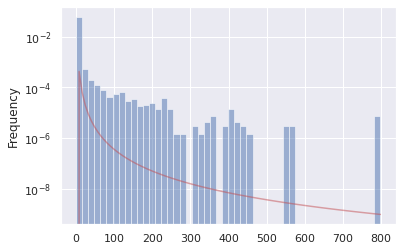

In [32]:
x = np.linspace(0., data.max(), 100)
ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5)
ax.plot(x, d.pdf(x), color='r', alpha=0.5)
ax.set_yscale('log')

/raid/wcrichto/flowistry-experiments/.env/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


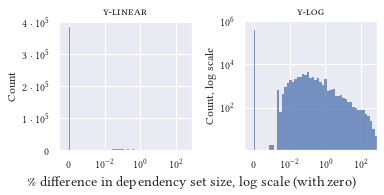

In [33]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Linux Libertine O']})
rc('text', **{'usetex': True, 'latex.preamble': r'\usepackage{libertine}\usepackage[libertine]{newtxmath}'})

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(5.5, 3.))

plot_ins(modular_metric, ax=ax1, xscale='symlog')
ax1.set_title('\\textsc{y-linear}')
ax1.set_yticklabels(['0'] + [f'${n} \cdot 10^5$' for n in [1,2,3,4]])

plot_ins(modular_metric, xscale='symlog', yscale='log', ax=ax2)
ax2.set_title('\\textsc{y-log}')
ax2.set_yticks([10e1, 10e3, 10e5])

for ax in [ax1, ax2]:
    ax.set_xticks([0, 10e-3, 10e-1, 10e1])

ax1.set_xlabel('')
ax2.set_xlabel('')
fig.supxlabel('\% difference in dependency set size, log scale (with zero)', y=0.1)

fig.tight_layout()
fig.savefig('eval-recurse-dist.pdf', bbox_inches='tight')

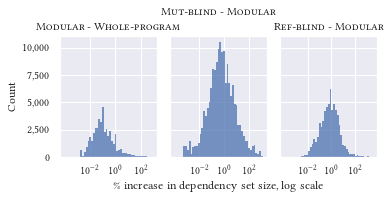

In [34]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(5.5, 3.), sharey=True)

kwargs = {'nz': True, 'xscale': 'log'}
plot_ins(modular_metric, ax=ax1, **kwargs)
ax1.set_title('\\textsc{Modular} - \\textsc{Whole-program}')
plot_ins(mutblind_metric, ax=ax2, **kwargs)
ax2.set_title('\\textsc{Mut-blind} - \\textsc{Modular}', y=1.125)
plot_ins(refblind_metric, ax=ax3, **kwargs)
ax3.set_title('\\textsc{Ref-blind} - \\textsc{Modular}')

# ax1.set_yticks([0, 25000, 50000])
for ax in [ax1, ax2, ax3]:
    ax.set_xticks([10e-3, 10e-1, 10e1])
ax1.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# ax1.set_ylabel('')
# ax3.set_ylabel('')
ax1.set_xlabel('')
ax3.set_xlabel('')

fig.tight_layout()

fig.savefig('eval-all-dist.pdf', bbox_inches='tight')

In [35]:
def stats(series):
    nz = len(series[series > 0]) / len(series)
    return f'{nz:.2f}, {1. - nz:.2f}, {series[series > 0].median():.2f}'

print('Modular:', stats(modular_metric))
print('MutBlind:', stats(mutblind_metric))
print('RefBlind:', stats(refblind_metric))

Modular: 0.10, 0.90, 0.10
MutBlind: 0.38, 0.62, 0.58
RefBlind: 0.15, 0.85, 0.76


In [36]:
g = mutblind_cond[mutblind_metric > 0].groupby('crate').size().rename('nz')
g2 = pd.concat([
    g, 
    mutblind_cond.groupby('crate').size().rename('total'), 
    mutblind_cond.groupby('crate').num_instructions.median().rename('avg_ins')], axis=1)
g2['frac'] = g2.nz / g2.total
g2.sort_values('frac')

,nz,total,avg_ins,frac
crate,,,,
rayon,2312,10695,24.0,0.216176
rg3d,13866,60928,85.0,0.227580
image,9846,40672,132.0,0.242083
Rocket,4369,12618,75.0,0.346251
rav1e,29539,78816,427.0,0.374784
rustls,9833,23884,108.0,0.411698
RustPython,43385,99679,117.0,0.435247
nalgebra,16592,37202,80.0,0.445998
sccache,11801,24705,202.0,0.477677


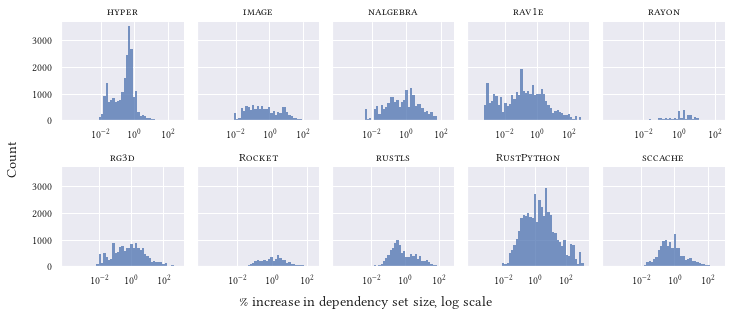

In [37]:
g = sns.FacetGrid(data=mutblind_cond, col='crate', col_order=sorted(CRATES, key=lambda s: s.lower()), 
                  col_wrap=5, sharex=False, height=2.3, aspect=0.9)
g.map_dataframe(lambda **kwargs: plot_ins(kwargs['data'].instructions_relative_base_frac, nz=True, xscale='log'))
g.set_titles('\\textsc{{{col_name}}}')
g.fig.supylabel('Count')
g.fig.supxlabel('\% increase in dependency set size, log scale', y=0.05)
for ax in g.axes.flat:
    ax.set_xticks([10e-3, 10e-1, 10e1])
    
g.fig.tight_layout()
g.fig.savefig('eval-crates.pdf', bbox_inches='tight')



In [38]:
whole_cond.groupby('reached_library').size()

reached_library
False     16955
True     412245
dtype: int64

In [39]:
modular_cond.groupby(['reached_library']).instructions_relative_frac.describe()[['count', 'mean', '50%']]

,count,mean,50%
reached_library,,,
False,16955.0,0.017542,0.0
True,412245.0,0.242779,0.0
